In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import gym
from copy import deepcopy
from scipy import stats
import os
import torch
import os.path as osp

In [ ]:
def print_2f(*args):
    __builtins__.print(*("%.2f" % a if isinstance(a, float) else a
                         for a in args))

def plot(X_tsne, y):
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne-x_min) / (x_max-x_min)
    plt.figure(figsize=(16,16))
    for i in range(X_norm.shape[0]):
        plt.scatter(X_norm[i, 0], X_norm[i, 1], color=plt.cm.Set1(y[i]))
    plt.show()

In [5]:
names = [['Ant-v3_sac_base' , 'Ant-v3_td3_base', 'atla_ppo_ant'],
         ['Humanoid-v3_sac_base', 'Humanoid-v3_td3_base', 'vanilla_ppo_humanoid'],
         ['Walker2d-v3_sac_base', 'Walker2d-v3_td3_base', 'vanilla_ppo_walker'],
         ['Hopper-v3_sac_base', 'Hopper-v3_td3_base', 'vanilla_ppo_hopper']
]
path  = '/home/lclan/spinningup/data/trajs'

In [55]:
import pickle
def get_trajs(algo_names, path):
    file_names = os.listdir(path)
    trajs = []
    for algo_name in algo_names:
        for file_name in file_names:
            if "trajs.pkl" not in file_name:
                continue
            if algo_name in file_name:
                print(file_name)
                trajs_file_name = osp.join(path,  file_name)
                with open(trajs_file_name, 'rb') as f: 
                    all_trajs = pickle.load(f)
                    trajs.append(all_trajs) 
                break
    return trajs

# human_trajs = get_trajs(names[1], path)

In [60]:
def get_mean(trajs):
    rets  = deepcopy(trajs[2])
    return sum(rets) / len(rets)

def get_env_name(name):
    if ('humanoid' in name) or ('Humanoid' in name):
        return 'Humanoid-v3'
    if ('halfcheetah' in name) or ('HalfCheetah' in name):
        return 'HalfCheetah-v3'
    if ('ant' in name) or ('Ant' in name):
        return 'Ant-v3'
    if ('hopper' in name) or  ('Hopper' in name) :
        return 'Hopper-v3'
    if ('walker' in name) or ('Walker' in name) :
        return 'Walker2d-v3'
    return 'unknown'



def restore_state(env, old_state):
    env.reset()
    env.sim.set_state(old_state)
    env.sim.forward()
    return env.get_obs()

def get_trajs_thr(trajs, top_ratio):
    rets = deepcopy(trajs[2])
    rets.sort()
    return rets[int(len(rets) * (1-top_ratio))]


def get_obs_from_trajs(trajs, top_ratio=0.5, use_obs=True):
    env_name = get_env_name(trajs[0])
    print(env_name)
    env = gym.make(env_name)
    ret = []
    thr = get_trajs_thr(trajs, top_ratio)
    print("thr: ", thr)
    x = 0
    for i in range(len(trajs[4])):
        if trajs[2][i] < thr:
            x += 1
            continue
        traj = trajs[4][i]
        for sampled_state in traj:
            if use_obs:
                o = restore_state(env, sampled_state[1])
            else:
                o = np.concatenate((sampled_state[1].qpos, sampled_state[1].qvel), axis=None)
            ret.append(o)
    print(x/len(trajs[4]))
    return ret
    

def get_top2_obs(env_trajs, use_obs=True):
    l = []
    for all_trajs in env_trajs:
        rets = []
        for trajs in all_trajs:
            # (algo_name, agent_name, rets, all_rewards, sampled_trajs)
            # rets = [ret_0, ret_1, ...,]
            # all_rewards = [[r00, r01, ...] [r10, r11 ....]]
            # sampled_trajs = [[(id, state), (), ()], []]
            rets.append(get_mean(trajs))
        rets = np.array(rets)
        sorted_ids = np.argsort(rets)
        print(rets)    
        print(sorted_ids)
        obs1 = get_obs_from_trajs(all_trajs[sorted_ids[-2]], use_obs=use_obs)
        obs2 = get_obs_from_trajs(all_trajs[sorted_ids[-3]], use_obs=use_obs)
        l.append((obs1, obs2))
    return l
        
    
# all_top2_obs  = get_top2_obs(human_trajs)

In [49]:
import random
def get_tsne_XY(all_top_obs, num=1000):
    x = []
    l = []
    i = 0
    ratio = num / len(all_top_obs[0][0])
    print(ratio)
    for top_obs in all_top_obs:
        for obs in top_obs:
            for s in obs:
                if random.random() < ratio:
                    x.append(s)
                    l.append(i)
            i += 1
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=521)
    xy = tsne.fit_transform(x)
    return xy, l

# xy, l =  get_tsne_XY(all_top2_obs, 20000)



In [69]:
def reduce10percent(xy, l):
    x = [a[0] for a in xy]
    y = [a[1] for a in xy]
    x.sort()
    lr = 0.02
    hr = 1-lr
    lx = x[int(lr*len(x))]
    hx = x[int(hr*len(x))]
    print(x[int(0.1*len(x))], x[int(0.9*len(x))])
    y.sort()
    ly = y[int(lr*len(y))]
    hy = y[int(hr*len(y))]
    print(y[int(0.1*len(y))], y[int(0.9*len(y))])
    xxyy = []
    ll = []
    for i in range(len(xy)):
        a = xy[i]
        if a[0] < lx:
            continue
        if a[0] > hx:
            continue
        if a[1] < ly:
            continue
        if a[1] > hy:
            continue
        xxyy.append(a)
        ll.append(l[i])
    return xxyy, ll

def plot(X_tsne, y):
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne-x_min) / (x_max-x_min)
    plt.figure(figsize=(16,16))
    names = ['sac_1', 'sac_2', 'td3_1', 'td3_2', 'ppo_1', 'ppo_2']
    for i in range(X_norm.shape[0]):
        plt.scatter(X_norm[i, 0], X_norm[i, 1], color=plt.cm.Set1(y[i]), label=names[y[i]])
    plt.legend()
    plt.show()

# xxyy, ll = reduce10percent(xy, l)




In [44]:
def random_reduce(xy, l, num=10000):
    xxyy = []
    ll = []
    ratio = num / len(xy)
    print(ratio)
    for i in range(len(xy)):
        if random.random() < ratio:
            xxyy.append(xy[i])
            ll.append(l[i])
    return xxyy, ll

# xxyy, ll = random_reduce(xxyy, ll)
    


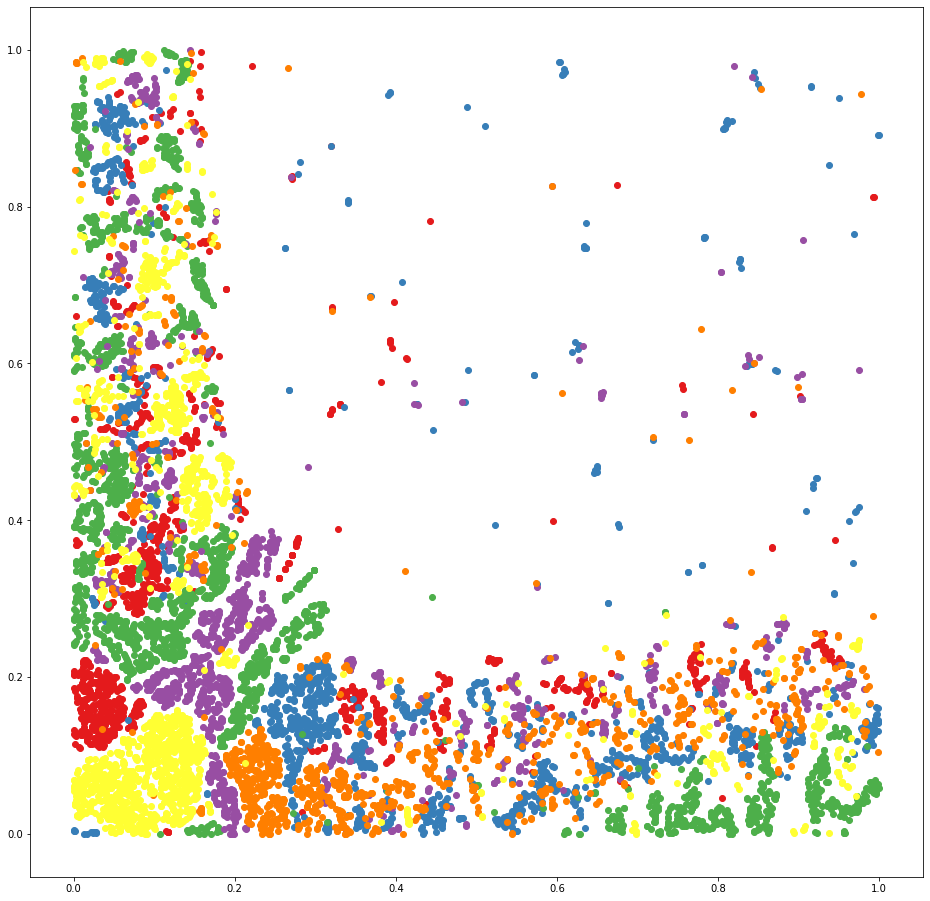

In [41]:
xxyy = np.array(xxyy)
plot(xxyy, ll)

In [58]:
def plot_all(names, path, use_obs = True):
    env_trajs = get_trajs(names, path)
    all_top2_obs = get_top2_obs(env_trajs, use_obs)
    xy, l = get_tsne_XY(all_top2_obs, 5000)
    xxyy, ll = reduce10percent(xy, l)
    xxyy, ll = random_reduce(xxyy, ll)
    xxyy = np.array(xxyy)
    plot(xxyy, ll)
    return xxyy, ll

# xxyy, ll = plot_all(names[0], path)
    


Walker2d-v3_sac_base_400_trajs.pkl
Walker2d-v3_td3_base_400_trajs.pkl
vanilla_ppo_walker_400_trajs.pkl
[4896.04601406 5457.18967009 5041.1146778  5692.45380083 5844.35497777
 6649.43988513 6178.54251274 5818.45639731 5862.41551566 5872.36733979
 5750.54187799 5524.79878046]
[ 0  2  1 11  3 10  7  4  8  9  6  5]
Walker2d-v3
thr:  6179.168077650294


/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0.5
Walker2d-v3
thr:  5872.828528142485
0.5
[6373.92656601 5799.20817163 6092.46399475 6604.82528219 5212.99875684
 5743.46545702 6029.1252093  4525.39102016 4279.66867452 5088.52790883
 6155.51949213 5156.62700415]
[ 8  7  9 11  4  5  1  6  2 10  0  3]
Walker2d-v3
thr:  6378.924466076991
0.5
Walker2d-v3
thr:  6160.969430064999
0.5
[1797.18978772 5145.78768228 4164.94099757 4020.81925834 3209.58065667
 4408.9164711  4424.3790636  3837.64332319 4386.58799832 5085.09217049
 5031.54152966 4703.61575661]
[ 0  4  7  3  2  8  5  6 11 10  9  1]
Walker2d-v3
thr:  5182.813977562141
0.5
Walker2d-v3
thr:  5082.930085731724
0.5
0.25
-56.619694 56.074024
-55.92032 55.93589
0.36321371494987653


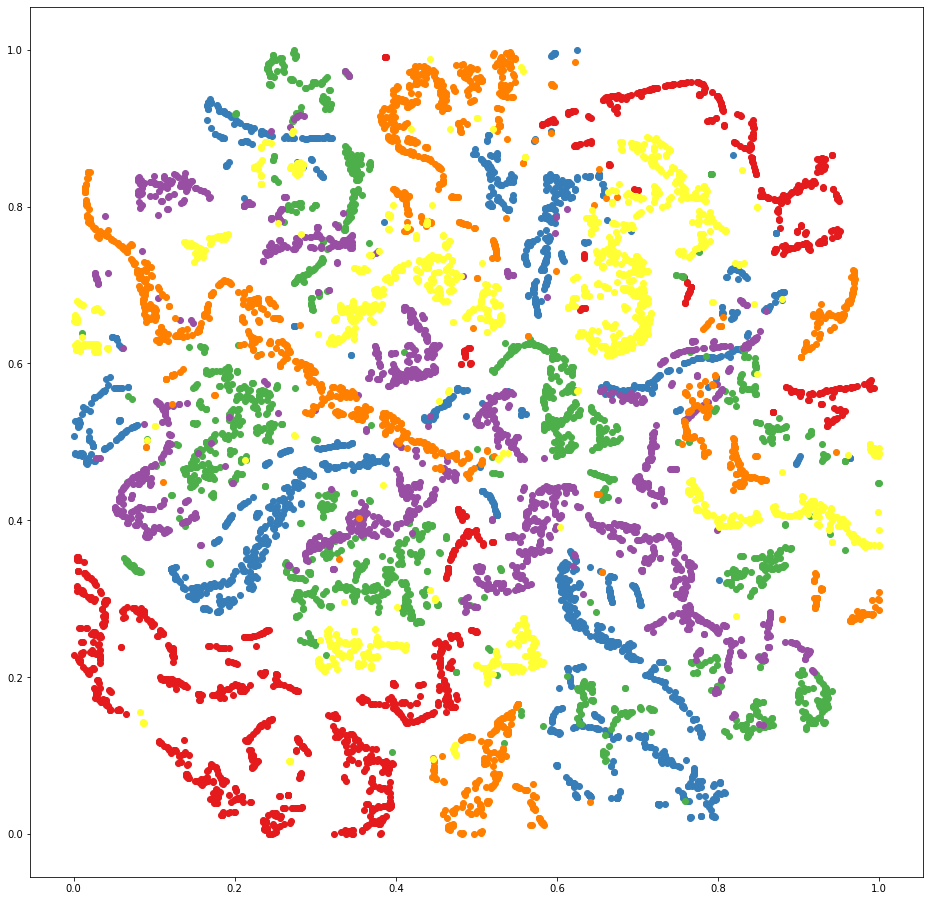

In [63]:
xxyy, ll = plot_all(names[2], path)

Humanoid-v3_sac_base_400_trajs.pkl
Humanoid-v3_td3_base_400_trajs.pkl
vanilla_ppo_humanoid_400_trajs.pkl
[6314.0533414  5587.00113422 5527.20171064 5706.19502155 5665.86801386
 5661.24444768 5505.70613297 5718.6663193  5706.41196711 5280.57680927
 5558.53868236 5517.28275138]
[ 9  6 11  2 10  1  5  4  3  8  7  0]
Humanoid-v3
thr:  5720.284732779205
0.5
Humanoid-v3
thr:  5730.308313494408
0.5
[4923.4880544  5560.49629527 5210.70042517 5977.38094219 5575.76908163
 5376.1918349  5458.07699976 5622.25475325 5224.18422968   60.77542704
 5382.27899682 5763.97081967]
[ 9  0  2  8  5 10  6  1  4  7 11  3]
Humanoid-v3
thr:  5775.427509245709
0.5
Humanoid-v3
thr:  5662.7289161820045
0.5
[5062.49410919 5129.68908413 4912.4685287  5250.52879701 5523.95139872
 5188.3267965  4832.18339015 5129.25184245 5186.86986563 5010.91516467
 5680.22668576]
[ 6  2  9  0  7  1  8  5  3  4 10]
Humanoid-v3
thr:  6067.348332006032


/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0.5
Humanoid-v3
thr:  5866.673945290204
0.5
0.25
-47.62312 50.24366
-48.480457 49.039265
0.3650434401693802


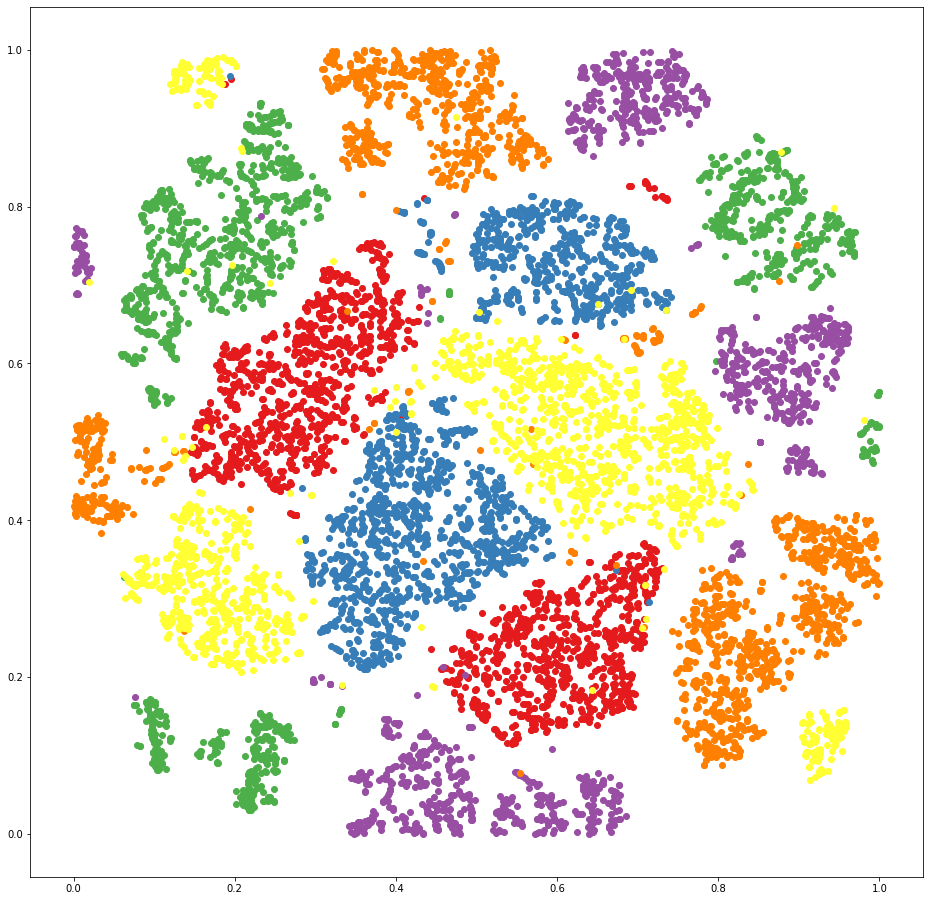

In [70]:
xxyy, ll = plot_all(names[1], path, use_obs=False)

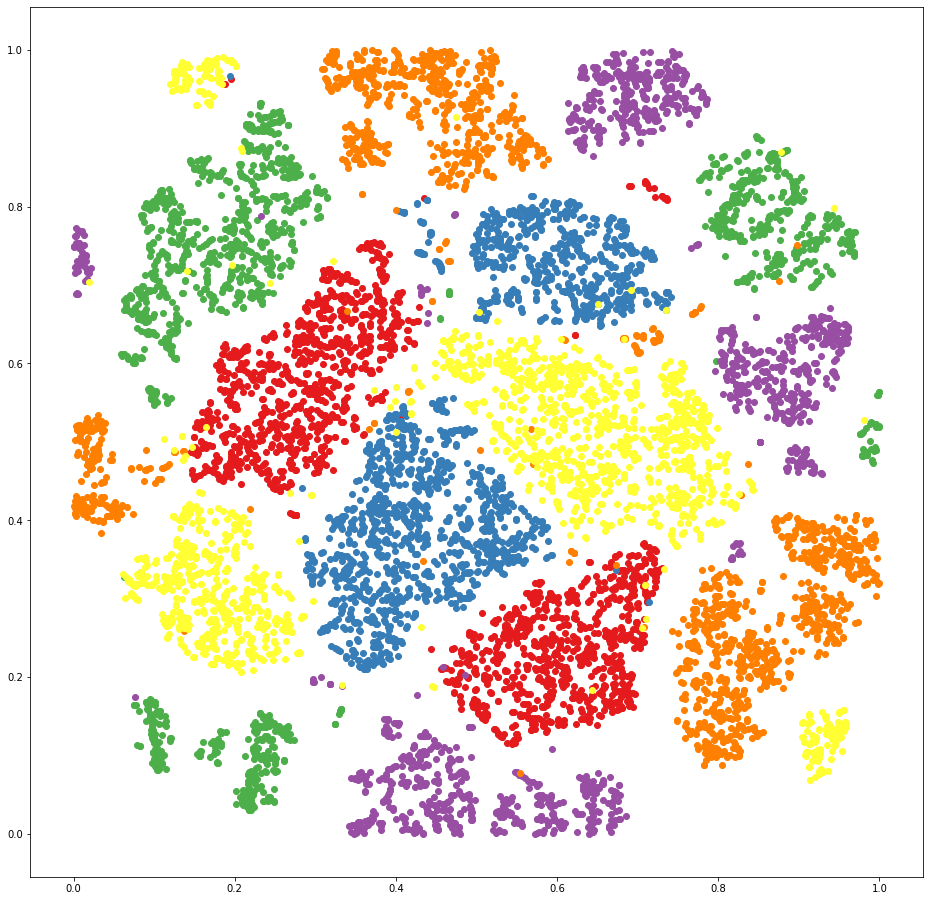

In [76]:
# def plot2(xy, l):
#     names = ['sac_1', 'sac_2', 'td3_1', 'td3_2', 'ppo_1', 'ppo_2']
#     fig, ax = plt.subplots()
#     for g in np.unique(l):
#         print(g)
#         ix = np.where(l == g)
#     ax.scatter(xy[ix], xy[ix], color = plt.cm.Set1(g), label = names[g])
#     # ax.legend()
#     plt.show()
# plot2(xxyy, ll)
# plot(xxyy, ll)
X_tsne = xxyy
y = ll
names = ['sac_1', 'sac_2', 'td3_1', 'td3_2', 'ppo_1', 'ppo_2']

x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne-x_min) / (x_max-x_min)
plt.figure(figsize=(16,16))
for i in range(X_norm.shape[0]):
    plt.scatter(X_norm[i, 0], X_norm[i, 1], color=plt.cm.Set1(y[i]), label=names[y[i]])
plt.legend()
plt.show()



Hopper-v3_sac_base_400_trajs.pkl
Hopper-v3_td3_base_400_trajs.pkl
vanilla_ppo_hopper_400_trajs.pkl
[3669.08225734 3681.50034453 3597.75591908 3657.73026007 3622.19433739
 3581.31908661 3506.56688992 3781.11856001 3553.53029956 3689.82108385
 3588.14490629 4084.98679838]
[ 6  8  5 10  2  4  3  0  1  9  7 11]
Hopper-v3
thr:  3782.5690588199996


/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0.5
Hopper-v3
thr:  3689.6853185487416
0.5
[3178.76539629 3421.81465488 3510.6536205  3584.84460821 3469.17964246
 3607.25796837 3353.31422923 3690.47900725 3844.73379825 3308.42700103
 3680.22268871 3597.87392292]
[ 0  9  6  1  4  2  3 11  5 10  7  8]
Hopper-v3
thr:  3696.7131326063923
0.5
Hopper-v3
thr:  3679.9499045115845
0.5
[3379.34637724 3044.1266518  3549.60009922 2956.9678713  2699.59772265
 3603.81864913 3268.24355244 3068.89205152 3297.58149296 3542.76729334
 2109.90230482 3260.04705772]
[10  4  3  1  7 11  6  8  0  9  2  5]
Hopper-v3
thr:  3550.7747162603987
0.5
Hopper-v3
thr:  3544.187977528939
0.5
0.25
-58.383396 57.748558
-55.70244 55.83589
0.35857716580608145


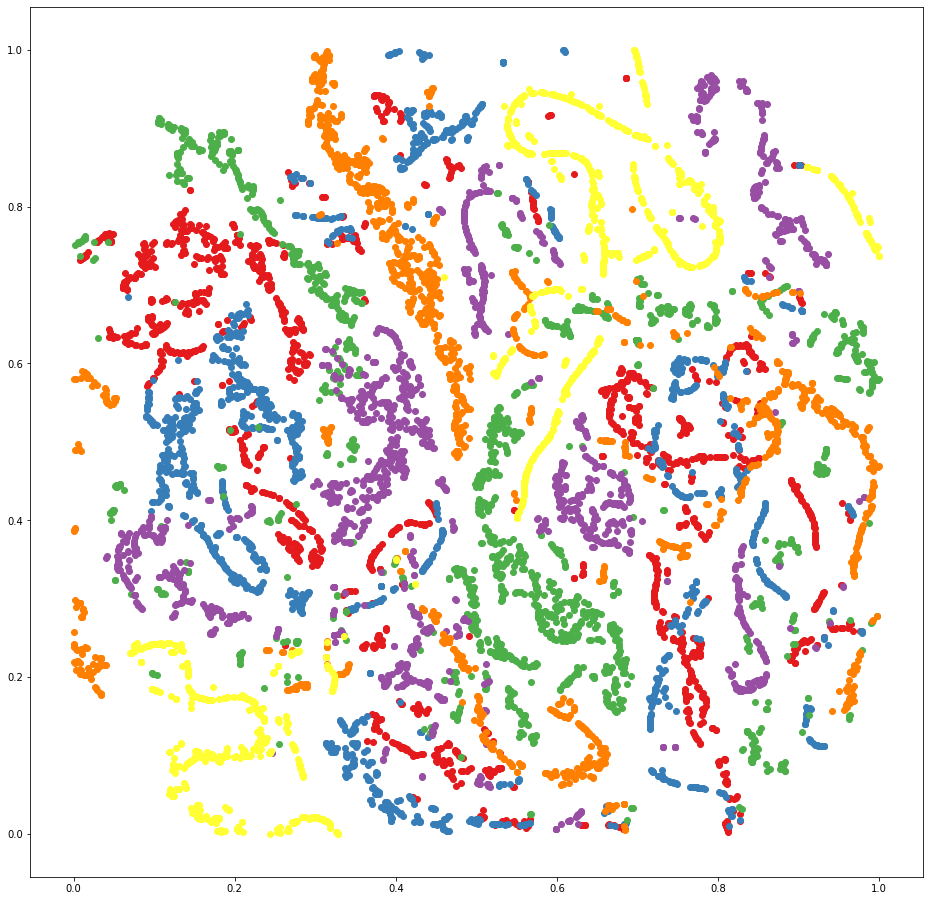

In [65]:
xxyy, ll = plot_all(names[3], path)

Hopper-v3_sac_base_400_trajs.pkl
Hopper-v3_td3_base_400_trajs.pkl
vanilla_ppo_hopper_400_trajs.pkl
[3669.08225734 3681.50034453 3597.75591908 3657.73026007 3622.19433739
 3581.31908661 3506.56688992 3781.11856001 3553.53029956 3689.82108385
 3588.14490629 4084.98679838]
[ 6  8  5 10  2  4  3  0  1  9  7 11]
Hopper-v3
thr:  3782.5690588199996
0.5
Hopper-v3
thr:  3689.6853185487416
0.5
[3178.76539629 3421.81465488 3510.6536205  3584.84460821 3469.17964246
 3607.25796837 3353.31422923 3690.47900725 3844.73379825 3308.42700103
 3680.22268871 3597.87392292]
[ 0  9  6  1  4  2  3 11  5 10  7  8]
Hopper-v3
thr:  3696.7131326063923
0.5
Hopper-v3
thr:  3679.9499045115845
0.5
[3379.34637724 3044.1266518  3549.60009922 2956.9678713  2699.59772265
 3603.81864913 3268.24355244 3068.89205152 3297.58149296 3542.76729334
 2109.90230482 3260.04705772]
[10  4  3  1  7 11  6  8  0  9  2  5]
Hopper-v3
thr:  3550.7747162603987


/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0.5
Hopper-v3
thr:  3544.187977528939
0.5
0.25
-57.902096 57.47503
-57.866352 56.29785
0.3658715059271184


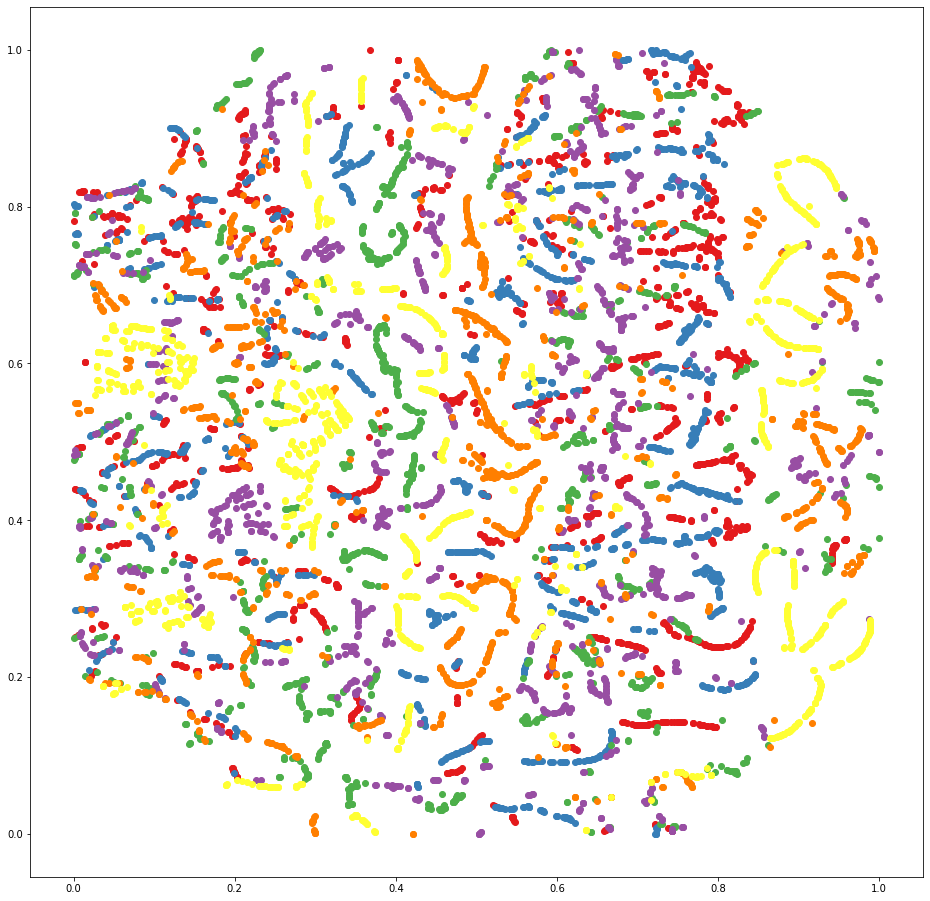

In [66]:
xxyy, ll = plot_all(names[3], path, use_obs=False)

Walker2d-v3_sac_base_400_trajs.pkl
Walker2d-v3_td3_base_400_trajs.pkl
vanilla_ppo_walker_400_trajs.pkl
[4896.04601406 5457.18967009 5041.1146778  5692.45380083 5844.35497777
 6649.43988513 6178.54251274 5818.45639731 5862.41551566 5872.36733979
 5750.54187799 5524.79878046]
[ 0  2  1 11  3 10  7  4  8  9  6  5]
Walker2d-v3
thr:  6179.168077650294
0.5
Walker2d-v3
thr:  5872.828528142485
0.5
[6373.92656601 5799.20817163 6092.46399475 6604.82528219 5212.99875684
 5743.46545702 6029.1252093  4525.39102016 4279.66867452 5088.52790883
 6155.51949213 5156.62700415]
[ 8  7  9 11  4  5  1  6  2 10  0  3]
Walker2d-v3
thr:  6378.924466076991
0.5
Walker2d-v3
thr:  6160.969430064999
0.5
[1797.18978772 5145.78768228 4164.94099757 4020.81925834 3209.58065667
 4408.9164711  4424.3790636  3837.64332319 4386.58799832 5085.09217049
 5031.54152966 4703.61575661]
[ 0  4  7  3  2  8  5  6 11 10  9  1]
Walker2d-v3
thr:  5182.813977562141


/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0.5
Walker2d-v3
thr:  5082.930085731724
0.5
0.25
-57.246468 56.988663
-54.725193 54.442738
0.3624895784246203


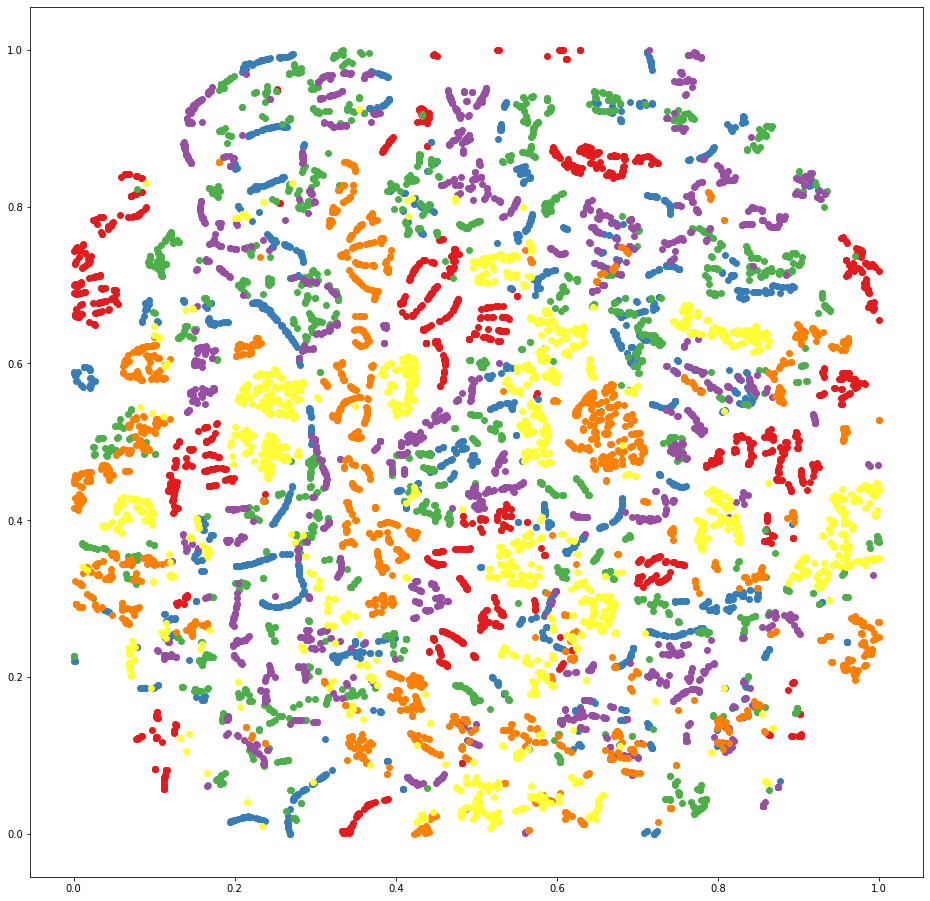

In [67]:
xxyy, ll = plot_all(names[2], path, use_obs=False)

Ant-v3_sac_base_400_trajs.pkl
Ant-v3_td3_base_400_trajs.pkl
atla_ppo_ant_400_trajs.pkl
[6181.76082245 6462.96727618 6066.90397372 6263.38030007 5973.77484382
 6076.43233148 6201.08944934 6089.35008082 6328.63850245 5759.24938813
 6153.72364532 6312.43748698]
[ 9  4  2  5  7 10  0  6  3 11  8  1]
Ant-v3
thr:  6491.678405025782
0.5
Ant-v3
thr:  6383.014461514273
0.5
[6382.72195523 6592.5901057  5945.84677933 6438.86891364 6321.76745229
 6044.60900321 5915.00149786 5883.76075126 6439.96320008 6345.31603487
 6218.78902935 3560.22458027]
[11  7  6  2  5 10  4  9  0  3  8  1]
Ant-v3
thr:  6740.434008777804
0.5
Ant-v3
thr:  6531.929325391324
0.5
[4411.33434075 4662.29057769 5082.72978066 4215.45877165 4585.32232629
 4653.57804411 4785.67609927 4777.76506948 4633.22468038 4119.34468423
 4276.89155859 4840.61973528]
[ 9  3 10  0  4  8  5  1  7  6 11  2]
Ant-v3
thr:  4932.233029668162


/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0.5
Ant-v3
thr:  4868.196781467924
0.5
0.25
-123.62257 133.22382
-31.394922 33.657116
0.3601137959595232


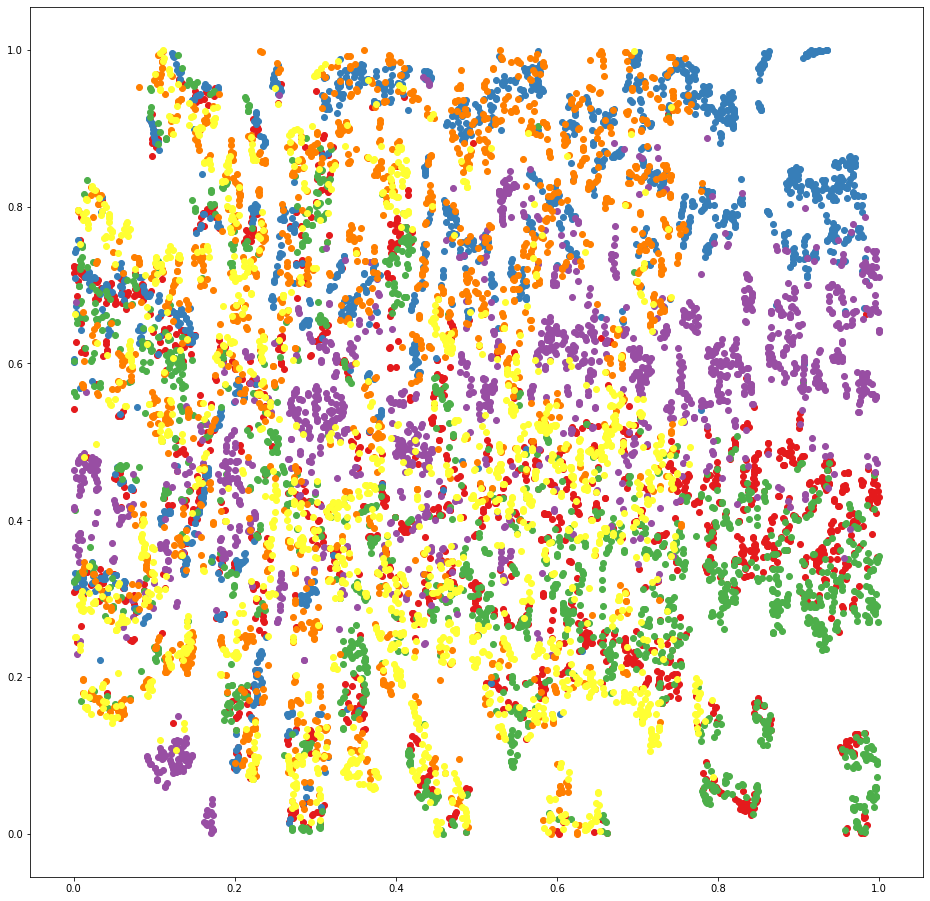

In [68]:
xxyy, ll = plot_all(names[0], path, use_obs=False)